# Seq2Seq_Attension
實現基礎版的Seq2Seq，輸入一個英文單字，模型將輸出一個對字母排序後的單字
<br>輸入 : hello
<br>輸出 : ehllo

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import time
import copy
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.python.layers.core import Dense

# 讀取數據

In [2]:
f = open('data/letters_source.txt', 'r', encoding = 'utf-8')
source_data = f.read()

f = open('data/letters_target.txt', 'r', encoding = 'utf-8')
target_data = f.read()

# 數據預處理

In [3]:
def extract_character_vocab(data):
    
    special_words = ['<PAD>' , '<UNK>' , '<GO>' , '<EOS>']
    
    words = []
    for line in data.split('\n'):
        for character in line:
            if character not in words:
                words.append(character)

    # 將四個特殊字加入詞庫       
    int_to_vocab = {idx: word for idx , word in enumerate(special_words + words)}
    vocab_to_int = dict(zip(int_to_vocab.values() , int_to_vocab.keys()))

    return int_to_vocab, vocab_to_int

In [4]:
source_int_to_letter , source_letter_to_int = extract_character_vocab(source_data)
target_int_to_letter , target_letter_to_int = extract_character_vocab(target_data)

# 將所有字母轉換成index
source_int = []
for line in source_data.split('\n'):
    temp = []
    for letter in line:
        temp.append(source_letter_to_int[letter])
    source_int.append(temp)    
        
target_int = []
for line in target_data.split('\n'):
    temp = []
    for letter in line:
        temp.append(target_letter_to_int[letter])
    temp = temp + [target_letter_to_int['<EOS>']]
    target_int.append(temp)      

In [5]:
# 超参数
# Number of Epochs
epochs = 60
# Batch Size
batch_size = 128
# RNN Size
rnn_hidden_unit = 50
# Number of Layers
num_layers = 1
# Embedding Size
encoding_embedding_size = 15
decoding_embedding_size = 15
# Learning Rate
learning_rate = 0.001

# Build Model

## 輸入層

In [6]:
input_data = tf.placeholder(tf.int32 , [None , None] , name = 'inputs')
targets = tf.placeholder(tf.int32 , [None , None] , name = 'targets')
lr = tf.placeholder(tf.float32 , name = 'learning_rate')

source_sequence_length = tf.placeholder(tf.int32 , [None ,] , name = 'source_sequence_length')
target_sequence_length = tf.placeholder(tf.int32 , [None ,] , name = 'target_sequence_length')
# 決定target序列最大長度（之後target_sequence_length和source_sequence_length會作為feed_dict的參數）
max_target_sequence_length = tf.reduce_max(target_sequence_length , name = 'max_target_len')

## Encoder

需要對source數據進行embedding，再傳入Decoder中的RNN

In [7]:
# input_data: 輸入tensor
# rnn_hidden_unit: rnn隱層結點數量
# num_layers: rnn cell的層數
# source_sequence_length: source數據的序列長度
# source_vocab_size: source數據的詞庫大小
# encoding_embedding_size: embedding的向量維度

# Encoder embedding
'''
encoder_embed_input = tf.contrib.layers.embed_sequence(input_data , source_vocab_size , encoding_embedding_size) 
                                                  ⇕ 相當於
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size , encoding_embedding_size]))
encoder_embed_input = tf.nn.embedding_lookup(encoder_embeddings , input_data)

若懶得寫兩行程式可以直接用tf.contrib.layers.embed_sequence這個函數
介紹 : https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence
'''
source_vocab_size = len(source_letter_to_int)
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size , encoding_embedding_size]))
encoder_embed_input = tf.nn.embedding_lookup(encoder_embeddings , input_data)


def get_lstm_cell(rnn_hidden_unit):
    lstm_cell = tf.contrib.rnn.LSTMCell(rnn_hidden_unit, 
                                        initializer = tf.random_uniform_initializer(-0.1 , 0.1))
    return lstm_cell

cell = tf.contrib.rnn.MultiRNNCell([get_lstm_cell(rnn_hidden_unit) for _ in range(num_layers)])

encoder_output, encoder_state = tf.nn.dynamic_rnn(cell, 
                                                  encoder_embed_input, 
                                                  sequence_length = source_sequence_length,
                                                  dtype = tf.float32)

## Decoder and Attention

In [8]:
# 預處理後的decoder輸入
# 在batch中每一筆data最前面加上<GO>，並移除最後一個字，所以每一筆data的詞的數目並無改變

# cut掉最後一個字
# ending = tf.strided_slice(targets , [0, 0] , [batch_size, -1] , [1, 1]) # 等同於 ending = tf.identity(targets[: , 0:-1])
ending = tf.identity(targets[: , 0:-1])
decoder_input = tf.concat([tf.fill([batch_size, 1] , target_letter_to_int['<GO>']) , ending] , axis = 1)

### tf.contrib.seq2seq.TrainingHelper:(Training 階段，還有其他種類的Helper)
### 訓練時採用teacher forcing，永遠把ground truth輸入給模型，不管模型前一步預測結果是否正確
此函數為Decoder端用來訓練的參數，這個函數不會把t-1時刻的輸出當作t時刻的輸入，而是把target中的真實質直接輸入給RNN<br>
主要參數是inputs與sequence_length，返回helper對象，可以做為Basic Decoder函數的參數
<br><br><br>

### tf.contrib.seq2seq.GreedyEmbeddingHelper:(Inference 階段，還有不同sample手段的Helper)
### 它和TrainingHelper的區別在於它會把t-1時刻的輸出經過embedding層作為t時刻的輸入
• greedy decoding：每一次把模型認為機率最大的 token 輸入給下一時刻<br>
• beam search decoding：每次保留 top k 的預測結果，解碼得到（近似） k best 序列 <br>
• sample decoding：每一步從模型預測的機率分布中隨機取樣一個 token 輸入給下一時刻

In [9]:
# decoding_embedding_size: embedding的向量維度
# num_layers: rnn cell的層數
# rnn_size: RNN單元的隱層結點數量
# target_sequence_length: target數據序列長度
# max_target_sequence_length: target數據序列最大長度
# encoder_state: encoder端編碼的狀態向量
# decoder_input: decoder端輸入

# 1. Embedding，需要對target數據進行embedding，再傳入Decoder中的RNN
target_vocab_size = len(target_letter_to_int)
decoder_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
decoder_embed_input = tf.nn.embedding_lookup(decoder_embeddings , decoder_input)

# 2. 建造Decoder中的RNN單元
def get_decoder_cell(rnn_hidden_unit):
    decoder_cell = tf.contrib.rnn.LSTMCell(rnn_hidden_unit,
                                           initializer = tf.random_uniform_initializer(-0.1 , 0.1))
    return decoder_cell
cell = tf.contrib.rnn.MultiRNNCell([get_decoder_cell(rnn_hidden_unit) for _ in range(num_layers)])
 
# 3. Output全連接層
output_layer = Dense(target_vocab_size,
                     kernel_initializer = tf.truncated_normal_initializer(mean = 0.0 , stddev = 0.1))
 
# 4. 加入Attention機制
attn_mech = tf.contrib.seq2seq.LuongAttention(num_units = rnn_hidden_unit ,
                                              memory = encoder_output ,
                                              memory_sequence_length = source_sequence_length)


attn_decoder = tf.contrib.seq2seq.AttentionWrapper(cell = cell ,
                                                   attention_mechanism = attn_mech , 
                                                   attention_layer_size = rnn_hidden_unit , 
                                                   alignment_history = True)
 
initial_state = attn_decoder.zero_state(batch_size , tf.float32).clone(cell_state = encoder_state)


# 5. Training decoder
with tf.variable_scope('decoder'):
    # tf.contrib.seq2seq.TrainingHelper即是採用Teacher Forcing的方法
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs = decoder_embed_input,
                                                        sequence_length = target_sequence_length,
                                                        time_major = False)
    # 建造decoder
    training_decoder = tf.contrib.seq2seq.BasicDecoder(attn_decoder,
                                                       training_helper,
                                                       initial_state,
                                                       output_layer) 
    
    # decoder_output包含 rnn_output 與 sample_id
    # rnn_output: [batch_size, decoder_targets_length, vocab_size]，保存decode每個時刻每個單詞的概率，可以用來計算loss
    # sample_id: [batch_size], tf.int32，保存最終的編碼結果，可以表示最後的答案
    training_decoder_output ,\
    training_final_state ,\
    training_final_sequence_lengths =\
    tf.contrib.seq2seq.dynamic_decode(training_decoder,                                          
                                      impute_finished = True,
                                      maximum_iterations = max_target_sequence_length)
    
    attention_matrices = training_final_state.alignment_history.stack(name = 'train_attention_matrix')

    
with tf.variable_scope('decoder'):
    
    tf.get_variable_scope().reuse_variables() 
    
    # 創建一個常量tensor並覆制為batch_size的大小
    start_tokens = tf.tile(tf.constant([target_letter_to_int['<GO>']], dtype = tf.int32),
                           [batch_size] , 
                           name='start_tokens')
    
    # GreedyEmbeddingHelper採取argmax抽樣演算法來得到輸出id，並且經過embedding層作為下一時刻的輸入
    predicting_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(decoder_embeddings ,
                                                                 start_tokens ,
                                                                 target_letter_to_int['<EOS>'])
    
    predicting_decoder = tf.contrib.seq2seq.BasicDecoder(attn_decoder,
                                                         predicting_helper,
                                                         initial_state,
                                                         output_layer)
  
    predicting_decoder_output ,\
    predicting_final_state ,\
    predicting_final_sequence_lengths =\
    tf.contrib.seq2seq.dynamic_decode(predicting_decoder,
                                      impute_finished = True,
                                      maximum_iterations = max_target_sequence_length)    

    # 產生attention矩陣，有助於最後可視化結果
    predicting_attention_matrices = predicting_final_state.alignment_history.stack(name = 'inference_attention_matrix')                                                                                    

In [10]:
training_logits = tf.identity(training_decoder_output.rnn_output ,  name = 'logits')
predicting_logits = tf.identity(predicting_decoder_output.sample_id ,  name = 'predictions')

'''
target_sequence_length : [4 , 2 , 3]

max_target_sequence_length : 8

=> masks的輸出長這樣 : 1 1 1 1 0 0 0 0  (4)
                       1 1 0 0 0 0 0 0  (2)
                       1 1 1 0 0 0 0 0  (3)
-> 0的部分代表是補0的地方，不列入loss的計算，可以加快運算速度
'''                
               
masks = tf.sequence_mask(target_sequence_length , 
                         max_target_sequence_length, 
                         dtype = tf.float32, 
                         name = 'masks')


with tf.variable_scope('optimization'):        
    # Loss function
    cost = tf.contrib.seq2seq.sequence_loss(training_logits,
                                            targets,
                                            masks)

    # Optimizer
    optimizer = tf.train.AdamOptimizer(lr)

    # Gradient Clipping
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
    train_op = optimizer.apply_gradients(capped_gradients)

## Batches

In [11]:
def get_batches(source , target , batch_index , batch_i):         
    source_array = np.array(source)      
    target_array = np.array(target)   
    source_batch = list(source_array[batch_index[batch_i]])
    target_batch = list(target_array[batch_index[batch_i]])
    
    max_sentence_source = max([len(sentence) for sentence in source_batch]) 
    max_sentence_target = max([len(sentence) for sentence in target_batch]) 
    
    # 將長度少於max_sentence的補0，使每個序列的長度都是max_sentence
    pad_source_batch , pad_target_batch = [] , []
    source_length , target_length = [] , []   
    for i in range(0 , batch_size):
        temp_source =  copy.deepcopy(source_batch[i])
        while len(temp_source) < max_sentence_source:
            temp_source.append(0)
        pad_source_batch.append(temp_source)    
        
        temp_target = copy.deepcopy(target_batch[i])
        while len(temp_target) < max_sentence_target:
            temp_target.append(0)
        pad_target_batch.append(temp_target)   
        
        # 記錄每條數據的長度
        source_length.append(len(source_batch[i]))
        target_length.append(len(target_batch[i]))
       
    pad_source_batch = np.array(pad_source_batch)
    pad_target_batch = np.array(pad_target_batch)
    source_length = np.array(source_length)
    target_length = np.array(target_length)
    
    return pad_source_batch , pad_target_batch , source_length , target_length

In [12]:
# 將數據集分割為train和validation
train_source = source_int[batch_size:]
train_target = target_int[batch_size:]
# 留出一個batch進行驗證
valid_source = source_int[:batch_size]
valid_target = target_int[:batch_size]

## Training

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch_i in range(0 , epochs):
    
    # 在每進行一個epoch前，把每個batch的index先決定出來
    batch_index = []
    temp = []
    count = 0 # 隨機決定index的開頭 
    while len(batch_index) <= 77:  # 1個batch裡只有77筆資料
        temp.append(count)
        count += 1
        if len(temp) == batch_size:
            batch_index.append(temp)
            temp = []
        if count == len(train_source):
            count = 0

    for batch_i in range(0 , 77):
        pad_train_source_batch , \
        pad_train_target_batch , \
        train_source_length , \
        train_target_length = get_batches(source = train_source ,
                                          target = train_target , 
                                          batch_index = batch_index , 
                                          batch_i = batch_i)
        
        _ , loss , predicting_logits_result =\
        sess.run([train_op , cost , predicting_logits], 
                 feed_dict = {input_data : pad_train_source_batch ,
                              targets : pad_train_target_batch ,
                              source_sequence_length: train_source_length , 
                              target_sequence_length : train_target_length  ,
                              lr: learning_rate})
        
        if batch_i % 30 == 0: # 每隔30個輪查看一下結果
            
            pad_valid_source_batch , \
            pad_valid_target_batch , \
            valid_source_length , \
            valid_target_length = get_batches(source = valid_source ,
                                              target = valid_target , 
                                              batch_index = batch_index , 
                                              batch_i = 0)
            
            validation_loss = sess.run(cost, 
                                      feed_dict = {input_data : pad_valid_source_batch ,
                                                   targets : pad_valid_target_batch ,
                                                   source_sequence_length: valid_source_length , 
                                                   target_sequence_length : valid_target_length})
            
            print('Epoch : {}/{} \nBatch : {}/{} \nTraining Loss : {:.3f} \nValidation loss: {:.3f}'
                  .format(epoch_i , epochs , 
                          batch_i , len(train_source) // batch_size , 
                          loss , validation_loss))
            
            index = np.random.randint(batch_size)
            print('Source : {}'.format([source_int_to_letter[i] for i in pad_train_source_batch[index]] ))
            print('Target : {}'.format([target_int_to_letter[i] for i in pad_train_target_batch[index]] ))
            print('Predict : {}\n'.format([target_int_to_letter[i] for i in predicting_logits_result[index]] ))
    
    
# 保存模型
saver = tf.train.Saver()
saver.save(sess , 'trained_model/save_net')
print('Model Trained and Saved')

Epoch : 0/60 
Batch : 0/77 
Training Loss : 3.406 
Validation loss: 3.392
Source : ['i', 'f', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['f', 'i', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['u', 'u', 'i', 'i', 'n', 'i', 's', 's']

Epoch : 0/60 
Batch : 30/77 
Training Loss : 2.949 
Validation loss: 2.947
Source : ['s', 'o', 'v', 'y', 't', '<PAD>', '<PAD>']
Target : ['o', 's', 't', 'v', 'y', '<EOS>', '<PAD>', '<PAD>']
Predict : ['f', '<EOS>', '<PAD>']

Epoch : 0/60 
Batch : 60/77 
Training Loss : 2.467 
Validation loss: 2.472
Source : ['s', 'i', 'r', 'e', 'n', 'w', 'g']
Target : ['e', 'g', 'i', 'n', 'r', 's', 'w', '<EOS>']
Predict : ['b', 'd', 'h', 'h', 'u', '<EOS>']

Epoch : 1/60 
Batch : 0/77 
Training Loss : 2.324 
Validation loss: 2.305
Source : ['i', 'f', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['f', 'i', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['g', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Epoch 

Epoch : 10/60 
Batch : 30/77 
Training Loss : 0.229 
Validation loss: 0.230
Source : ['v', 'f', 'p', 'b', 'o', 'n', 'q']
Target : ['b', 'f', 'n', 'o', 'p', 'q', 'v', '<EOS>']
Predict : ['b', 'f', 'n', 'o', 'p', 's', 'v', '<EOS>']

Epoch : 10/60 
Batch : 60/77 
Training Loss : 0.182 
Validation loss: 0.208
Source : ['b', 'i', 'g', 'n', 'd', 'n', 'c']
Target : ['b', 'c', 'd', 'g', 'i', 'n', 'n', '<EOS>']
Predict : ['b', 'c', 'd', 'g', 'i', 'n', 'n', '<EOS>']

Epoch : 11/60 
Batch : 0/77 
Training Loss : 0.172 
Validation loss: 0.190
Source : ['n', 'c', 'p', 'q', '<PAD>', '<PAD>', '<PAD>']
Target : ['c', 'n', 'p', 'q', '<EOS>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['c', 'n', 'p', 'p', '<EOS>', '<PAD>', '<PAD>', '<PAD>']

Epoch : 11/60 
Batch : 30/77 
Training Loss : 0.155 
Validation loss: 0.152
Source : ['n', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['n', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['n', '<EOS>', '<PAD>', '<PAD>', '<PAD>

Epoch : 21/60 
Batch : 0/77 
Training Loss : 0.011 
Validation loss: 0.032
Source : ['x', 'r', 'g', 'g', 'x', 'a', 'd']
Target : ['a', 'd', 'g', 'g', 'r', 'x', 'x', '<EOS>']
Predict : ['a', 'd', 'g', 'g', 'r', 'x', 'x', '<EOS>']

Epoch : 21/60 
Batch : 30/77 
Training Loss : 0.011 
Validation loss: 0.016
Source : ['b', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['b', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['b', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Epoch : 21/60 
Batch : 60/77 
Training Loss : 0.010 
Validation loss: 0.029
Source : ['q', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['q', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['q', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Epoch : 22/60 
Batch : 0/77 
Training Loss : 0.009 
Validation loss: 0.034
Source : ['s', 'd', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['d', 's', '<EO

Epoch : 31/60 
Batch : 30/77 
Training Loss : 0.003 
Validation loss: 0.013
Source : ['m', 'm', 'e', 't', 'm', 'z', '<PAD>']
Target : ['e', 'm', 'm', 'm', 't', 'z', '<EOS>', '<PAD>']
Predict : ['e', 'm', 'm', 'm', 't', 'z', '<EOS>', '<PAD>']

Epoch : 31/60 
Batch : 60/77 
Training Loss : 0.003 
Validation loss: 0.014
Source : ['d', 'g', 'g', 'w', 'o', 'm', 'e']
Target : ['d', 'e', 'g', 'g', 'm', 'o', 'w', '<EOS>']
Predict : ['d', 'e', 'g', 'g', 'm', 'o', 'w', '<EOS>']

Epoch : 32/60 
Batch : 0/77 
Training Loss : 0.003 
Validation loss: 0.018
Source : ['s', 'd', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['d', 's', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['d', 's', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Epoch : 32/60 
Batch : 30/77 
Training Loss : 0.002 
Validation loss: 0.012
Source : ['v', 'j', 'e', 'z', '<PAD>', '<PAD>', '<PAD>']
Target : ['e', 'j', 'v', 'z', '<EOS>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['e', 'j', 'v', 'z', '<EOS>

Epoch : 41/60 
Batch : 30/77 
Training Loss : 0.001 
Validation loss: 0.008
Source : ['m', 'o', 'r', 'i', 'f', '<PAD>', '<PAD>']
Target : ['f', 'i', 'm', 'o', 'r', '<EOS>', '<PAD>', '<PAD>']
Predict : ['f', 'i', 'm', 'o', 'r', '<EOS>', '<PAD>', '<PAD>']

Epoch : 41/60 
Batch : 60/77 
Training Loss : 0.001 
Validation loss: 0.013
Source : ['p', 'd', 'c', 'g', 'g', '<PAD>', '<PAD>']
Target : ['c', 'd', 'g', 'g', 'p', '<EOS>', '<PAD>', '<PAD>']
Predict : ['c', 'd', 'g', 'g', 'p', '<EOS>', '<PAD>', '<PAD>']

Epoch : 42/60 
Batch : 0/77 
Training Loss : 0.001 
Validation loss: 0.014
Source : ['o', 'b', 'z', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['b', 'o', 'z', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['b', 'o', 'z', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Epoch : 42/60 
Batch : 30/77 
Training Loss : 0.001 
Validation loss: 0.008
Source : ['t', 'd', 'o', 'g', 'g', 'v', 'z']
Target : ['d', 'g', 'g', 'o', 't', 'v', 'z', '<EOS>']
Predict : ['d', 'g', 'g', 'o', 't', '

Epoch : 51/60 
Batch : 60/77 
Training Loss : 0.001 
Validation loss: 0.010
Source : ['s', 'v', 'h', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['h', 's', 'v', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['h', 's', 'v', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Epoch : 52/60 
Batch : 0/77 
Training Loss : 0.000 
Validation loss: 0.013
Source : ['j', 'c', 's', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['c', 'j', 's', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['c', 'j', 's', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Epoch : 52/60 
Batch : 30/77 
Training Loss : 0.000 
Validation loss: 0.009
Source : ['o', 'j', 'z', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['j', 'o', 'z', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predict : ['j', 'o', 'z', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Epoch : 52/60 
Batch : 60/77 
Training Loss : 0.000 
Validation loss: 0.010
Source : ['q', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Target : ['q', '<EO

## Testing

In [14]:
import os    
sess = tf.Session()
new_saver = tf.train.import_meta_graph(os.path.join('trained_model/save_net.meta'))
new_saver.restore(sess, tf.train.latest_checkpoint(os.path.join('trained_model')))

graph = tf.get_default_graph()
input_data = graph.get_tensor_by_name('inputs:0')
targets = graph.get_tensor_by_name('targets:0')
source_sequence_length = graph.get_tensor_by_name('source_sequence_length:0')
target_sequence_length = graph.get_tensor_by_name('target_sequence_length:0')
logits = graph.get_tensor_by_name('predictions:0')

input_word = 'common'

test_source = [] 
for letter in input_word:
    if letter not in source_letter_to_int.keys():
        test_source.append(source_letter_to_int['<UNK>'])
    else:
        test_source.append(source_letter_to_int[letter])
        
test_target = []
for letter in input_word:
    if letter not in target_letter_to_int.keys():
        test_target.append(target_letter_to_int['<UNK>'])
    else:
        test_target.append(target_letter_to_int[letter])

test_target = test_target + [target_letter_to_int['<EOS>']]  

batch_size = 128
test_source = [test_source] * batch_size
test_target = [test_target] * batch_size
test_source_length = [len(i) for i in test_source]
test_target_length = [len(i) for i in test_target]

test_source = np.array(test_source)
test_target = np.array(test_target)
test_source_length = np.array(test_source_length)
test_target_length = np.array(test_target_length)

answer = sess.run(logits , feed_dict = {input_data : test_source ,
                                        targets : test_target ,
                                        source_sequence_length: test_source_length , 
                                        target_sequence_length : test_target_length})
answer = answer[0 , :]
answer_to_letter = []
for num in answer:
    answer_to_letter.append(target_int_to_letter[num])
answer_to_letter       

INFO:tensorflow:Restoring parameters from trained_model\save_net


['c', 'm', 'm', 'n', 'o', 'o', '<EOS>']

['c', 's', 'r', 'q', 'x', '<PAD>', '<PAD>']
['c', 'q', 'r', 's', 'x', '<EOS>', '<PAD>', '<PAD>']


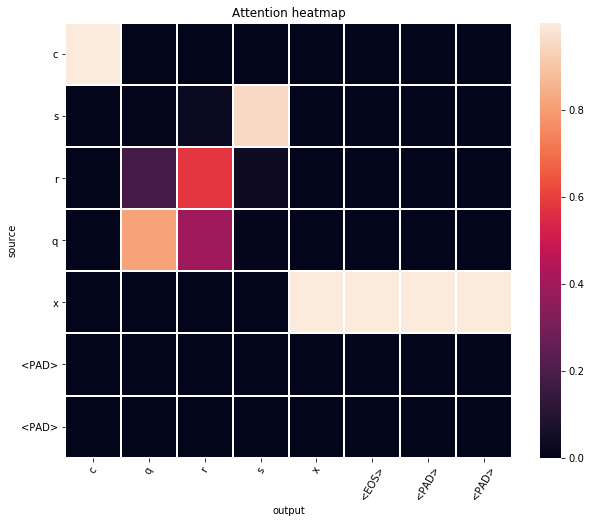

In [15]:
att , predicting_logits_ = sess.run([predicting_attention_matrices , predicting_logits], 
                                     feed_dict = {input_data : pad_train_source_batch ,
                                                  targets : pad_train_target_batch ,
                                                  source_sequence_length: train_source_length , 
                                                  target_sequence_length : train_target_length})    


# 隨機取一個樣本 i 畫出注意力矩陣
i = 4
matrix = att[:, i, :].T
src = pad_train_source_batch[i, :]
tgt = predicting_logits_[i , :]    

src_letter , tgt_letter = [] , []
for item in src:
    src_letter.append(source_int_to_letter[item])
for item in tgt :
    tgt_letter.append(target_int_to_letter[item])
print(src_letter)
print(tgt_letter)

df = pd.DataFrame(matrix , index = src_letter , columns = tgt_letter)
plt.figure(figsize=(10 , 8))
ax = sns.heatmap(df , linewidths = 1)
ax.set_xlabel('output')
ax.set_ylabel('source')
plt.xticks(rotation = 60)
plt.yticks(rotation = 0)
ax.set_title('Attention heatmap')
plt.show()